In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from datetime import datetime, timedelta
import os
from collections import defaultdict

from pandas.core.apply import relabel_result


def fix_data(data):
    fixed_data = data.copy()
    for df in fixed_data:
        df['Exercise duration_s'] /= 100
        temp = df['Sleep type duration_minutes'].copy()
        df['Sleep type duration_minutes'] = df['Sleep duration_minutes']
        df['Sleep duration_minutes'] = temp

    return fixed_data

def augment_data(df):
    # --- Parse datetime ---
    df = df.copy()
    df['Datetime'] = pd.to_datetime(df['Datetime'], format='%Y=%m-%d %H:%M', errors='coerce')
    df = df.sort_values('Datetime').reset_index(drop=True)

    # --- Compute durations (in minutes) ---
    if 'Exercise duration_s' in df.columns and 'Sleep duration_minutes' in df.columns:
        df['Duration_min'] = (
            df['Exercise duration_s'].fillna(0) // 60  # convert seconds to minutes
            + df['Sleep duration_minutes'].fillna(0)
        )
    elif 'Exercise duration_s' in df.columns:
        df['Duration_min'] = df['Exercise duration_s'].fillna(0) // 60
    elif 'Sleep duration_minutes' in df.columns:
        df['Duration_min'] = df['Sleep duration_minutes'].fillna(0)
    else:
        raise ValueError("Expected 'Exercise duration_s' and/or 'Sleep duration_minutes' columns.")
    # --- Build expanded records ---
    augmented_rows = []
    for i, row in df.iterrows():
        current_time = row['Datetime']
        duration = int(row['Duration_min'])
        activity = row['Activity_Type']

        # Compute gap to previous record
        if i > 0:
            prev_time = df.loc[i-1, 'Datetime']
            gap_minutes = int((current_time - prev_time).total_seconds() // 60 - 1)
        else:
            gap_minutes = duration  # no previous record, so just use duration

        # Use whichever is shorter
        expand_minutes = min(duration, gap_minutes)
        if expand_minutes <= 0:
            # No expansion needed, just append the current record
            augmented_rows.append({'Datetime': current_time, 'Activity_Type': activity})
            continue

        # Generate timestamps for each minute before current_time (exclusive)
        times = pd.date_range(
            end=current_time,
            periods=expand_minutes + 1,  # +1 to include current_time
            freq='min'
        )

        # Append one row per minute
        for t in times:
            augmented_rows.append({'Datetime': t, 'Activity_Type': activity})
    # --- Return new DataFrame ---
    augmented_df = pd.DataFrame(augmented_rows)
    return augmented_df.reset_index(drop=True)

def compute_activity_histogram_transition_matrices_target(data, activity_state_dict, max_gap_hours = 8):
    activity_state_dict_inverse = {val:key for key, val in activity_state_dict.items()}
    num_states = len(activity_state_dict.keys())
    max_gap_hours = 8

    #Get target distribution
    activity_histogram = np.ones((24, num_states))
    for df in data:
        # Map the activity strings to numeric codes in one go
        activities = df['Activity_Type'].map(activity_state_dict_inverse)

        # Convert to datetime efficiently (only once)
        times = pd.to_datetime(df['Datetime'], format='%Y=%m-%d %H:%M', errors='coerce')
        hours = times.dt.hour.to_numpy()

        # Use NumPy histogram2d to bin by (hour, activity)
        h, _, _ = np.histogram2d(
            hours,
            activities,
            bins=[np.arange(25), np.arange(len(activity_state_dict_inverse) + 1)]
        )
        # Accumulate into your main histogram
        activity_histogram += h.astype(int)

    target = np.sum(activity_histogram, axis = 0)
    target = target / np.sum(target)

    activity_histogram /= np.sum(activity_histogram, axis = 1, keepdims = True)

    #Augment data
    augmented_data = [augment_data(df) for df in data]

    #Activity distribution, use ones for pseudocounts
    # activity_histogram = np.ones((24, num_states))
    transition_matrices = np.ones((24, num_states, num_states))
    for df in augmented_data:
        times = pd.to_datetime(df['Datetime'], format='%Y=%m-%d %H:%M', errors='coerce')
        hours = times.dt.hour.to_numpy()

        # Map activity types to integer codes
        activities = df['Activity_Type'].map(activity_state_dict_inverse).to_numpy()

        # --- Compute time differences and hours ---
        time_diffs = (times.diff().dt.total_seconds() / 3600.0).to_numpy()
        current_hours = times.dt.hour.to_numpy()

        # --- Iterate through pairs (vectorized indexing is tricky here) ---
        hour = 0
        i = 0
        j = 0
        for t in range(len(df) - 1):
            i = activities[t]
            j = activities[t + 1]
            gap = time_diffs[t + 1]
            if np.isnan(gap) or gap > max_gap_hours:
                continue
            hour = current_hours[t]
            # activity_histogram[hour][i] += 1
            transition_matrices[hour][i][j] += 1
        # activity_histogram[hour][j] += 1

    activity_histogram /= np.sum(activity_histogram, axis = 1, keepdims = True)
    transition_matrices /= np.sum(transition_matrices, axis = 2, keepdims = True)

    return activity_histogram, transition_matrices, target

def compute_cpdfs(data, activity_state_dict):
    activity_state_dict_inverse = {val:key for key, val in activity_state_dict.items()}
    # Initialize accumulators
    combined_hr = defaultdict(lambda: defaultdict(int))
    combined_ad_tier3 = defaultdict(lambda: defaultdict(int))

    tier_3_dependencies = {
        'Sleep duration_minutes': 'Sleep type duration_minutes',
        'Exercise duration_s': 'Calories burned_kcal'
    }

    for df in data:
        working_df = df.copy()
        working_df['activity duration'] = (
            working_df['Sleep duration_minutes'].fillna(0) +
            working_df['Exercise duration_s'].fillna(0)
        )
        working_df['tier 3 var'] = (
            working_df['Calories burned_kcal'].fillna(0) +
            working_df['Sleep type duration_minutes'].fillna(0)
        )

        # --- Heart Rate Histogram per Activity ---
        activity_hr_hist = (
            working_df.groupby('Activity_Type')['Heart rate___beats/minute']
            .value_counts()
        )

        for (activity, hr), count in activity_hr_hist.items():
            combined_hr[activity_state_dict_inverse[activity]][hr] += count

        # --- Activity Duration × Tier 3 Histogram per Activity ---
        # Build tuple keys for joint histograms
        working_df['pair'] = list(zip(working_df['activity duration'], working_df['tier 3 var']))
        activity_ad_tier3_hist = (
            working_df.groupby('Activity_Type')['pair']
            .value_counts()
        )

        for (activity, pair), count in activity_ad_tier3_hist.items():
            combined_ad_tier3[activity_state_dict_inverse[activity]][pair] += count


    # --- Convert to normalized conditional PDFs ---
    def normalize_nested_dict(d):
        normalized = {}
        for key, subdict in d.items():
            total = sum(subdict.values())
            if total > 0:
                normalized[key] = {k: v / total for k, v in subdict.items()}
            else:
                normalized[key] = {}
        return normalized

    cpdfs_hr = normalize_nested_dict(combined_hr)
    cpdfs_ad_tier3 = normalize_nested_dict(combined_ad_tier3)

    return cpdfs_hr, cpdfs_ad_tier3




data_dir = 'SyntheticData'
data = fix_data([pd.read_csv(path) for path in glob.glob(data_dir + '/*.csv') if 'User' in path])

activity_state_dict = {
    0: 'No Physical Activity',
    1: 'REM Sleep',
    2: 'Light Sleep',
    3: 'Running',
    4: 'Walking',
    5: 'Floors Climbed'
}

activity_histogram, transition_matrices, target = compute_activity_histogram_transition_matrices_target(data, activity_state_dict, max_gap_hours = 8)
cpmfs_hr, cpmfs_ad_tier3 = compute_cpdfs(data, activity_state_dict)

In [2]:
def matrix_factorize(matrix, p=1):
    eigenvalues, eigenvectors = np.linalg.eig(matrix)
    real_factorized_matrix = np.real(eigenvectors @ np.diag(np.nan_to_num(np.exp(1/p * np.log(1e-6+eigenvalues)), nan=0.0)) @ np.linalg.inv(eigenvectors)).astype(np.float64)
    real_factorized_matrix = np.maximum(0, np.minimum(1, real_factorized_matrix))
    stochastic_factorized_matrix = real_factorized_matrix / real_factorized_matrix.sum(axis=1, keepdims=True)
    return stochastic_factorized_matrix


def pmf_to_pmf_and_cdf_array_1d(pmf_dict):
    """
    Convert a PMF dict {value: prob_mass} into arrays suitable for sampling.

    Returns:
        values (np.ndarray): sorted unique values
        cdf (np.ndarray): cumulative probabilities in [0, 1]
    """
    # Sort PMF by key
    values, probs = zip(*sorted(pmf_dict.items()))
    values = np.concat([(0,)+values])
    probs = np.concat([(0, )+probs])
    # probs = np.array(probs, dtype=float)

    # Normalize (in case not already normalized)
    probs /= probs.sum()

    # Compute CDF
    cdf = np.cumsum(probs)
    cdf[-1] = 1.0  # Ensure exact 1.0

    return np.array(values), probs, cdf

def sample_from_cdf(values, cdf, n_samples=1):
    """
    Sample from an empirical CDF using linear interpolation.

    Args:
        values (np.ndarray): Sorted 1D array of support values (shape N,).
        cdf (np.ndarray): Corresponding cumulative probabilities in [0, 1] (shape N,).
        n_samples (int): Number of samples to draw.

    Returns:
        samples (np.ndarray): shape (n_samples,)
    """
    if not np.all(np.diff(cdf) >= 0):
        raise ValueError("CDF must be non-decreasing.")
    if cdf[0] > 0 or cdf[-1] < 1:
        raise ValueError("CDF must start near 0 and end near 1.")

    # Generate uniform random numbers
    u = np.random.rand(n_samples)

    # Linear interpolation from uniform samples to value domain
    samples = np.interp(u, cdf, values)

    return samples


def hierarchical_sample_from_pmf(pmf_dict, n_samples=1):
    """
    Hierarchical sampling from a multidimensional discrete PMF.

    Args:
        pmf_dict (dict): {(x1, x2, ..., xD): prob_mass}, any dimensionality.
        n_samples (int): number of samples to draw.

    Returns:
        samples (np.ndarray): shape (n_samples, D)
    """
    # Normalize the joint PMF
    total_prob = sum(pmf_dict.values())
    if total_prob == 0:
        raise ValueError("Total probability mass is zero.")
    pmf = {k: v / total_prob for k, v in pmf_dict.items()}

    # Determine number of dimensions
    first_key = next(iter(pmf))
    D = len(first_key)
    samples = np.zeros((n_samples, D), dtype=object)

    # --- Precompute conditional probability tables ---
    # Level 0: marginal P(x0)
    marginal_0 = defaultdict(float)
    for key, p in pmf.items():
        marginal_0[key[0]] += p

    # For each subsequent variable, precompute conditional PMFs
    cond_tables = [None]  # cond_tables[d] = {prefix: {x_d: P(x_d | prefix)}}
    for d in range(1, D):
        cond_d = defaultdict(lambda: defaultdict(float))
        for key, p in pmf.items():
            prefix = key[:d]
            cond_d[prefix][key[d]] += p
        # Normalize conditionals for each prefix
        for prefix, subpmf in cond_d.items():
            total = sum(subpmf.values())
            for x in subpmf:
                subpmf[x] /= total
        cond_tables.append(cond_d)

    # --- Sampling ---
    for i in range(n_samples):
        # sample first variable from marginal
        xs = []
        x0_vals, x0_probs = zip(*sorted(marginal_0.items()))
        x0_cdf = np.cumsum(x0_probs)
        u = np.random.rand()
        x0 = x0_vals[np.searchsorted(x0_cdf, u)]
        xs.append(x0)

        # sequentially sample each next variable
        for d in range(1, D):
            prefix = tuple(xs)
            cond_d = cond_tables[d][prefix]
            vals, probs = zip(*sorted(cond_d.items()))
            cdf = np.cumsum(probs)
            u = np.random.rand()
            x = vals[np.searchsorted(cdf, u)]
            xs.append(x)

        samples[i, :] = xs

    return np.array(samples, dtype=object)

def tier_1(activity_histogram, transition_matrices, target, start_time, end_time, heat_step_size, warm_up_period):
    """
    activity_histogram: np.array of shape (24, num_states)
    transition_matrices: np.array of shape (24, num_states, num_states)
    target: np.array of shape (num_states,)
    start_time: datetime
    end_time: datetime
    heat_step_size: float
    warm_up_period: int

    Returns synth_activity_sequence: pd.DataFrame of shape (T, 2)
    """
    synth_activity_sequence = []
    K = len(target)
    T = int((end_time - start_time).total_seconds() // 60)
    current_time = start_time
    h = current_time.hour
    activity_probs = activity_histogram[h].copy()
    transition_matrix = matrix_factorize(transition_matrices[h].copy(), p = 60)
    beta = np.ones(K)
    for t in range(T+1):
        current_time = current_time + timedelta(minutes = 1)
        h = current_time.hour
        if t % 60 == 0:
            activity_probs = activity_histogram[h].copy()
            transition_matrix = matrix_factorize(transition_matrices[h].copy(), p = 60)
            beta = np.ones(K)
        else:
            activity_probs = activity_probs @ transition_matrix

        if t > warm_up_period:
            beta = np.maximum(0, np.minimum(1, beta + heat_step_size  * (target - activity_probs)))
            for k in range(K):
                excess = min(1, max(0, transition_matrix[k][k] - beta[k]))
                transition_matrix[k] += excess / (K-1)
                transition_matrix[k][k] = beta[k]
        synth_activity = np.random.choice(K, p = activity_probs / np.sum(activity_probs))
        synth_activity_sequence.append(pd.DataFrame({'Datetime': current_time, 'Activity_Type': synth_activity}, index = [t]))
    synth_activity_sequence = pd.concat(synth_activity_sequence)
    return synth_activity_sequence

def tier_2_3(synth_activity_sequence, cpmfs_hr, cpmfs_ad_tier3, chain_len = 1):

    def pmf_variance(values, pmf):
        mean = sum(x * p for x, p in zip(values, pmf))
        mean_sq = sum((x**2) * p for x, p in zip(values, pmf))
        return mean_sq - mean**2

    heart_rates = []
    pmfs_cdfs = {key:[pmf_to_pmf_and_cdf_array_1d(value)] for key, value in cpmfs_hr.items()}

    #Heart rate
    i = 0
    while i < len(synth_activity_sequence):
        activity = synth_activity_sequence['Activity_Type'].iloc[i]
        values, pmf, cdf = pmfs_cdfs[activity][0]
        subchain = []
        subchain.extend(sample_from_cdf(values, cdf))
        prop_variance = pmf_variance(values, pmf)
        for j in range(chain_len):
            current = subchain[-1]
            proposal = np.random.normal(loc = current, scale = np.sqrt(prop_variance))
            p_current = np.interp(current, values, pmf)
            p_proposal = np.interp(proposal, values, pmf)
            alpha = min(1, p_proposal/p_current)
            if np.random.rand() < alpha:
                subchain.append(proposal)
            else:
                subchain.append(current)
        subchain = np.array(subchain)
        heart_rates.extend(list(subchain[1:]))
        i += chain_len

    # Pre-allocate columns with NaN
    ad_tier_3_df = pd.DataFrame({
        'Calories burned_kcal': np.nan,
        'Exercise duration_s': np.nan,
        'Sleep duration_minutes': np.nan,
        'Sleep type duration_minutes': np.nan,
        'Floors climbed___floors': np.nan
    }, index=synth_activity_sequence.index)

    # Handle deterministic cases first
    no_activity_idx = synth_activity_sequence['Activity_Type'].isin([0])
    floors_idx = synth_activity_sequence['Activity_Type'] == 5

    ad_tier_3_df.loc[floors_idx, 'Floors climbed___floors'] = 1

    # Group remaining by activity type
    for activity, group_idx in synth_activity_sequence[~synth_activity_sequence['Activity_Type'].isin([0, 5])].groupby('Activity_Type').groups.items():
        cpmf_dict = cpmfs_ad_tier3[activity]

        # Sample once per row in the group
        samples = np.array([hierarchical_sample_from_pmf(cpmf_dict)[0] for _ in range(len(group_idx))])

        if activity in [1, 2]:  # Sleeping
            ad_tier_3_df.loc[group_idx, 'Sleep duration_minutes'] = samples[:, 0]
            ad_tier_3_df.loc[group_idx, 'Sleep type duration_minutes'] = samples[:, 1]
        elif activity in [3, 4]:  # Exercise
            ad_tier_3_df.loc[group_idx, 'Exercise duration_s'] = samples[:, 0]
            ad_tier_3_df.loc[group_idx, 'Calories burned_kcal'] = samples[:, 1]
    return pd.concat([synth_activity_sequence, pd.Series(heart_rates, name = 'Heart rate___beats/minute'), ad_tier_3_df], axis = 1)

start_time = datetime(2022, 12, 8, 0, 0)
end_time = datetime(2022, 12, 22, 0, 0)
heat_step_size = 0.05
warm_up_period = 2000
output_dir = 'sim_alpha_0_05_warmup_2000'
for i in range(1):
    datetime_activity = tier_1(activity_histogram, transition_matrices, target, start_time, end_time, heat_step_size, warm_up_period)
    synth_record_full = tier_2_3(datetime_activity, cpmfs_hr, cpmfs_ad_tier3)
    # synth_record_full.to_csv(os.path.join(output_dir, f'SynthUser{i}'))




C:\Users\Darren\AppData\Local\Temp\ipykernel_35448\1548115997.py:3: RuntimeWarning: invalid value encountered in log
  real_factorized_matrix = np.real(eigenvectors @ np.diag(np.nan_to_num(np.exp(1/p * np.log(1e-6+eigenvalues)), nan=0.0)) @ np.linalg.inv(eigenvectors)).astype(np.float64)
C:\Users\Darren\AppData\Local\Temp\ipykernel_35448\1548115997.py:220: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2.0 1.0 6.0 ... 5.0 6.0 4.0]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  ad_tier_3_df.loc[group_idx, 'Sleep duration_minutes'] = samples[:, 0]
C:\Users\Darren\AppData\Local\Temp\ipykernel_35448\1548115997.py:221: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2.0 1.0 3.0 ... 3.0 3.0 2.0]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
 

# Grid Study Analysis

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import wasserstein_distance, ks_2samp, entropy
from scipy.spatial.distance import jensenshannon
from sklearn.metrics import pairwise_distances
import itertools

# ========== CONFIGURATION ==========

# Variables of interest
variables = [
    "Activity_Type",
    "Heart rate___beats/minute",
    "Calories burned_kcal",
    "Exercise duration_s",
    "Sleep duration_minutes",
    "Sleep type duration_minutes",
    "Floors climbed___floors"
]

# ========== HELPER FUNCTIONS ==========

def compute_jsd(p, q, bins=50):
    """Compute Jensen–Shannon Divergence for continuous data."""
    hist_range = (min(p.min(), q.min()), max(p.max(), q.max()))
    p_hist, _ = np.histogram(p, bins=bins, range=hist_range, density=True)
    q_hist, _ = np.histogram(q, bins=bins, range=hist_range, density=True)
    p_hist /= p_hist.sum()
    q_hist /= q_hist.sum()
    jsd = jensenshannon(p_hist, q_hist, base=2) ** 2
    return jsd


def distance_correlation(x, y, random_state=None):
    """
    Compute distance correlation between two 1D arrays.
    If lengths differ, randomly subsample the larger array to match the smaller one.
    """
    x, y = np.asarray(x), np.asarray(y)

    # Handle unequal lengths
    if len(x) != len(y):
        n = min(len(x), len(y))
        rng = np.random.default_rng(random_state)
        if len(x) > len(y):
            x = rng.choice(x, size=n, replace=False)
        else:
            y = rng.choice(y, size=n, replace=False)

    # Ensure 2D shape for pairwise distances
    x = x.reshape(-1, 1)
    y = y.reshape(-1, 1)

    # Compute pairwise distance matrices
    a = pairwise_distances(x)
    b = pairwise_distances(y)

    # Double centering
    A = a - a.mean(axis=0)[None, :] - a.mean(axis=1)[:, None] + a.mean()
    B = b - b.mean(axis=0)[None, :] - b.mean(axis=1)[:, None] + b.mean()

    # Compute distance covariance and variances
    dcov = np.sqrt((A * B).mean())
    dvar_x = np.sqrt((A * A).mean())
    dvar_y = np.sqrt((B * B).mean())

    # Return distance correlation
    return 0.0 if dvar_x * dvar_y == 0 else dcov / np.sqrt(dvar_x * dvar_y)

def compare_data(df1, df2, match_datetimes = False, input = 'real'):

    # Ensure both contain the same columns
    missing_cols = [v for v in variables if v not in df1.columns or v not in df2.columns]
    if missing_cols:
        raise ValueError(f"Missing columns in one or both CSVs: {missing_cols}")

    # --- Check and convert datetime columns ---
    if 'Datetime' not in df1.columns or 'Datetime' not in df2.columns:
        raise ValueError("Both CSVs must contain a 'Datetime' column for alignment.")

    # Convert to pandas datetime (handles mixed formats automatically)
    format = '%Y=%m-%d %H:%M'
    if input == 'synth':
        format = '%Y-%m-%d %H:%M:%S'
    df1['Datetime'] = pd.to_datetime(df1['Datetime'], format=format )
    df2['Datetime'] = pd.to_datetime(df2['Datetime'], format='%Y=%m-%d %H:%M')

    # Drop rows with invalid datetimes
    df1 = df1.dropna(subset=['Datetime'])
    df2 = df2.dropna(subset=['Datetime'])

    # Drop duplicate timestamps (keep the first occurrence)
    df1 = df1.drop_duplicates(subset=['Datetime'], keep='first')
    df2 = df2.drop_duplicates(subset=['Datetime'], keep='first')

    # --- Align df1 to df2's timestamps ---
    # (Assuming exact timestamp matches are desired)
    if match_datetimes:
        df1 = df1[df1['Datetime'].isin(df2['Datetime'])].reset_index(drop=True)

    # ========== COMPUTE STATISTICS ==========

    results = []

    for var in variables:
        x = df1[var].dropna()
        y = df2[var].dropna()

        # Skip if either is empty
        if len(x) == 0 or len(y) == 0:
            print(f"Skipping {var}: one or both DataFrames are empty.")
            results.append((var, np.nan, np.nan, np.nan, np.nan))
            continue

        # Decide metric type
        if var == "Activity_Type" or x.dtype == object:
            # Discrete / categorical → JSD only
            p = x.value_counts(normalize=True)
            q = y.value_counts(normalize=True)
            common_idx = p.index.union(q.index)
            p = p.reindex(common_idx, fill_value=0)
            q = q.reindex(common_idx, fill_value=0)
            jsd = jensenshannon(p, q)
            results.append((var, np.nan, np.nan, jsd, np.nan))
        else:
            # Continuous → Wasserstein, KS, JSD, Distance correlation
            w = wasserstein_distance(x, y)
            ks = ks_2samp(x, y).statistic
            jsd = compute_jsd(x, y)
            dcorr = distance_correlation(x.values, y.values)
            results.append((var, w, ks, jsd, dcorr))

    # ========== OUTPUT RESULTS ==========

    results_df = pd.DataFrame(
        results,
        columns=["Variable", "Wasserstein", "KS_statistic", "JSD", "Distance_correlation"]
    )

    return results_df


# self_comparison_result_list = []
# activity_state_dict_inverse = {val:key for key, val in activity_state_dict.items()}
# for i in range(len(data)):
#     print(i)
#     for j in range(i+1, len(data)):
#         df = data[i].copy()
#         ref_df = data[j].copy()
#         df['Activity_Type'] = df['Activity_Type'].map(activity_state_dict_inverse)
#         ref_df['Activity_Type'] = ref_df['Activity_Type'].map(activity_state_dict_inverse)
#         results_df = compare_data(df, ref_df, match_datetimes = False, input = 'real')
#         self_comparison_result_list.append(results_df)
# avg_self_comparison_result_df = pd.concat(self_comparison_result_list).groupby('Variable').mean().reset_index()
# std_self_comparison_result_df = pd.concat(self_comparison_result_list).groupby('Variable').std().reset_index()
# results_dir = 'results_grid_study'
# avg_self_comparison_result_df.to_csv(os.path.join(results_dir, f'reference_avg.csv'), index=False)
# std_self_comparison_result_df.to_csv(os.path.join(results_dir, f'reference_std.csv'), index=False)
comparison_result_list = []
base_dir = '' #put working directory here
# sim_dir = 'sim_alpha_0_warmup_0'
alpha_grid = [0, 5, 10, 20]
warmup_grid = [4000, 8000]
# alpha_grid = [10]
# warmup_grid = [2000]
activity_state_dict_inverse = {val:key for key, val in activity_state_dict.items()}
for alpha in alpha_grid:
    for warmup in warmup_grid:
        sim_dir = f'sim_alpha_{alpha}_warmup_{warmup}'
        print(sim_dir)
        sim_data = [pd.read_csv(filepath) for filepath in glob.glob(os.path.join(base_dir, sim_dir, '*.csv'))]
        for df in sim_data:
            for ref_df in data:
                df_copy = df.copy()
                ref_df_copy = ref_df.copy()
                df_copy['Activity_Type'] = df_copy['Activity_Type'].map(activity_state_dict_inverse)
                ref_df_copy['Activity_Type'] = ref_df_copy['Activity_Type'].map(activity_state_dict_inverse)
                results_df = compare_data(df_copy, ref_df_copy, match_datetimes = True, input = 'synth')
                comparison_result_list.append(results_df)

        avg_comparison_result_df = pd.concat(comparison_result_list).groupby('Variable').mean().reset_index()
        std_comparison_result_df = pd.concat(comparison_result_list).groupby('Variable').std().reset_index()
        results_dir = 'results_grid_study'
        avg_comparison_result_df.to_csv(os.path.join(results_dir, f'{sim_dir}_avg.csv'), index=False)
        std_comparison_result_df.to_csv(os.path.join(results_dir, f'{sim_dir}_std.csv'), index=False)


sim_alpha_0_warmup_4000
sim_alpha_0_warmup_8000
sim_alpha_5_warmup_4000
sim_alpha_5_warmup_8000
sim_alpha_10_warmup_4000
sim_alpha_10_warmup_8000
sim_alpha_20_warmup_4000
sim_alpha_20_warmup_8000


In [14]:
import os
import pandas as pd

alpha_grid = [0, 5, 10, 20]
warmup_grid = [0, 2000, 4000, 8000]

# === Metric dictionaries ===
wasserstein = {}
jensenshannon = {}
ks_statistic = {}
distance_correlation = {}

wasserstein_std = {}
jensenshannon_std = {}
ks_statistic_std = {}
distance_correlation_std = {}

reference_avg = pd.read_csv(os.path.join(results_dir, 'reference_avg.csv'))
reference_avg = reference_avg.drop(columns=['Variable'])

reference_std = pd.read_csv(os.path.join(results_dir, 'reference_std.csv'))
reference_std = reference_std.drop(columns=['Variable'])
reference_var = reference_std ** 2

# === Loop over configurations ===
for alpha in alpha_grid:
    for warmup in warmup_grid:
        # --- Load mean and std CSVs ---
        df_avg = pd.read_csv(os.path.join(results_dir, f'sim_alpha_{alpha}_warmup_{warmup}_avg.csv'))
        df_std = pd.read_csv(os.path.join(results_dir, f'sim_alpha_{alpha}_warmup_{warmup}_std.csv'))


        # --- Clean up ---
        df_avg = df_avg.drop(columns=['Variable'])
        df_std = df_std.drop(columns=['Variable'])
        df_var = df_std ** 2

        # --- Compute absolute and relative differences ---
        abs_diff = (df_avg - reference_avg).abs()
        rel_diff = ((df_avg - reference_avg) / reference_avg).abs()

        abs_diff_var = df_var + reference_var
        rel_diff_var = abs_diff_var / (reference_avg ** 2)

        # --- Store mean values ---
        wasserstein[(alpha, warmup)] = (abs_diff['Wasserstein'].mean(), rel_diff['Wasserstein'].mean())
        jensenshannon[(alpha, warmup)] = (abs_diff['JSD'].mean(), rel_diff['JSD'].mean())
        ks_statistic[(alpha, warmup)] = (abs_diff['KS_statistic'].mean(), rel_diff['KS_statistic'].mean())
        distance_correlation[(alpha, warmup)] = (abs_diff['Distance_correlation'].mean(), rel_diff['Distance_correlation'].mean())

        # --- Store std values (abs + rel, same structure) ---
        wasserstein_std[(alpha, warmup)] = (np.sqrt(abs_diff_var['Wasserstein'].mean()), np.sqrt(rel_diff_var['Wasserstein'].mean()))
        jensenshannon_std[(alpha, warmup)] = (np.sqrt(abs_diff_var['JSD'].mean()), np.sqrt(rel_diff_var['JSD'].mean()))
        ks_statistic_std[(alpha, warmup)] = (np.sqrt(abs_diff_var['KS_statistic'].mean()), np.sqrt(rel_diff_var['KS_statistic'].mean()))
        distance_correlation_std[(alpha, warmup)] = (np.sqrt(abs_diff_var['Distance_correlation'].mean()), np.sqrt(rel_diff_var['Distance_correlation'].mean()))

print("Wasserstein:", wasserstein)
print("Wasserstein_std:", wasserstein_std)
print("Jensen-Shannon:", jensenshannon)
print("Jensen-Shannon_std:", jensenshannon_std)
print("KS Statistic:", ks_statistic)
print("KS Statistic_std:", ks_statistic_std)
print("Distance Correlation:", distance_correlation)
print("Distance Correlation_std:", distance_correlation_std)


Wasserstein: {(0, 0): (np.float64(0.9870303837604545), np.float64(0.11088540208406975)), (0, 2000): (np.float64(1.104148871587941), np.float64(0.11802917159181273)), (0, 4000): (np.float64(1.6177122232644934), np.float64(0.1431043206728086)), (0, 8000): (np.float64(1.9370687589023152), np.float64(0.14877379739189836)), (5, 0): (np.float64(5.491883302079265), np.float64(0.11154427858456635)), (5, 2000): (np.float64(7.4288652132091935), np.float64(0.12792581728422575)), (5, 4000): (np.float64(3.3892187693458653), np.float64(0.1261986727875348)), (5, 8000): (np.float64(3.9602701609320086), np.float64(0.12380306007514566)), (10, 0): (np.float64(10.139401215987746), np.float64(0.15179256782331305)), (10, 2000): (np.float64(17.352945039337822), np.float64(0.274858135405763)), (10, 4000): (np.float64(5.7893132791217825), np.float64(0.12591255227785295)), (10, 8000): (np.float64(5.977130741696704), np.float64(0.12497073218052454)), (20, 0): (np.float64(13.099906827183455), np.float64(0.2037991

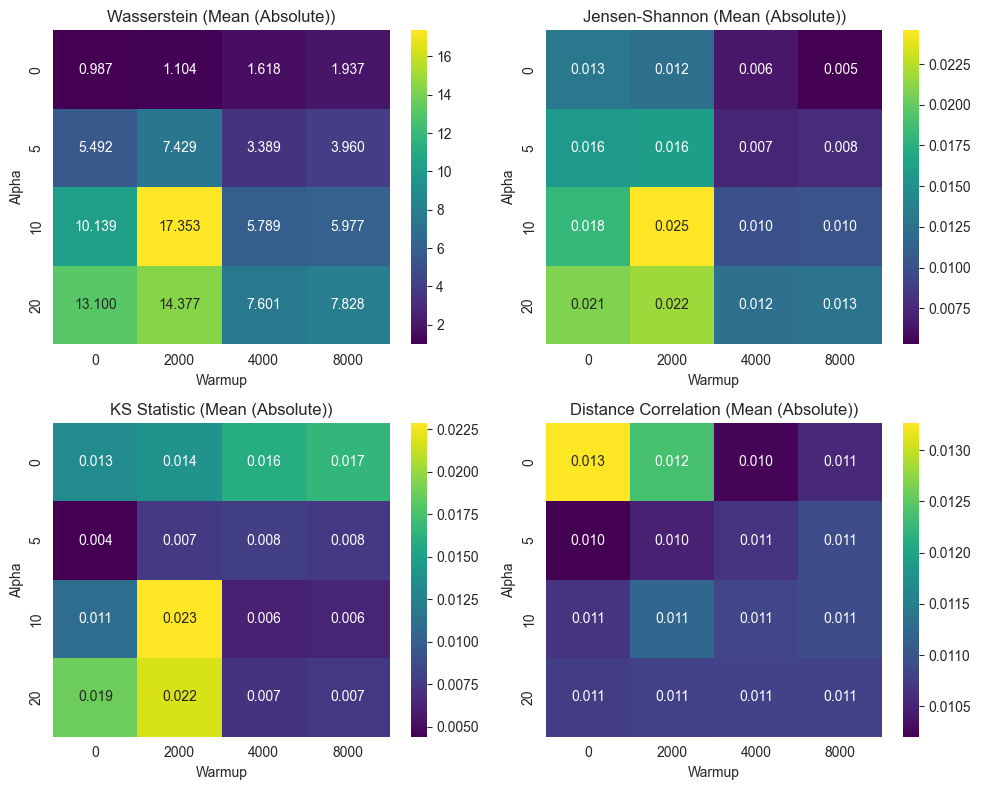

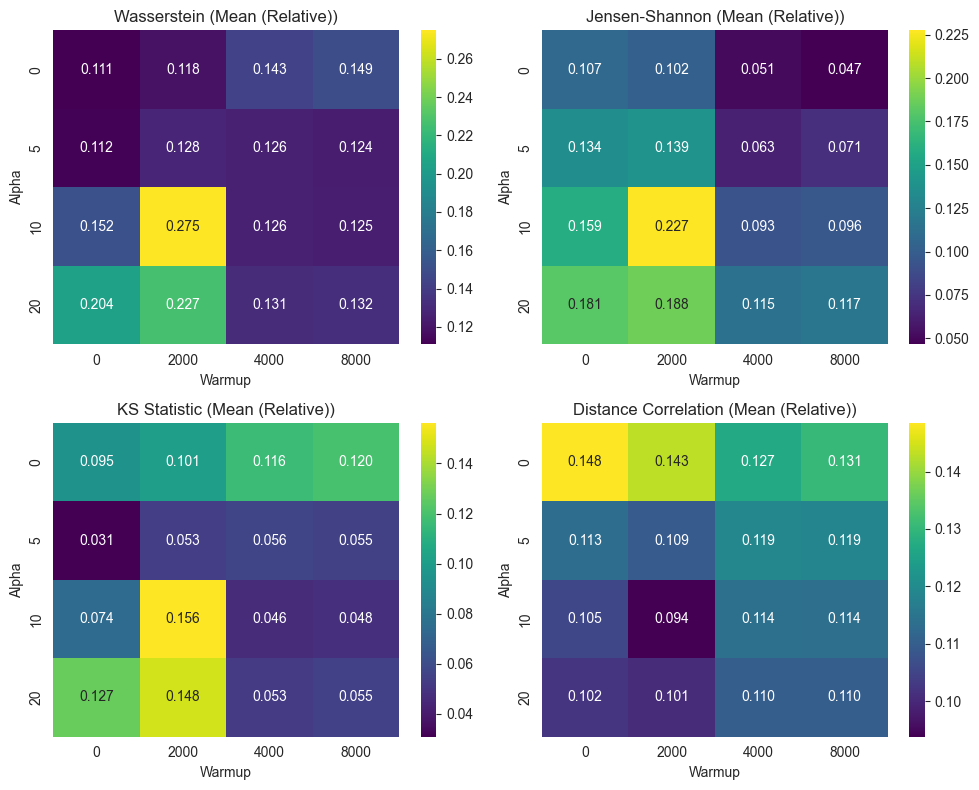

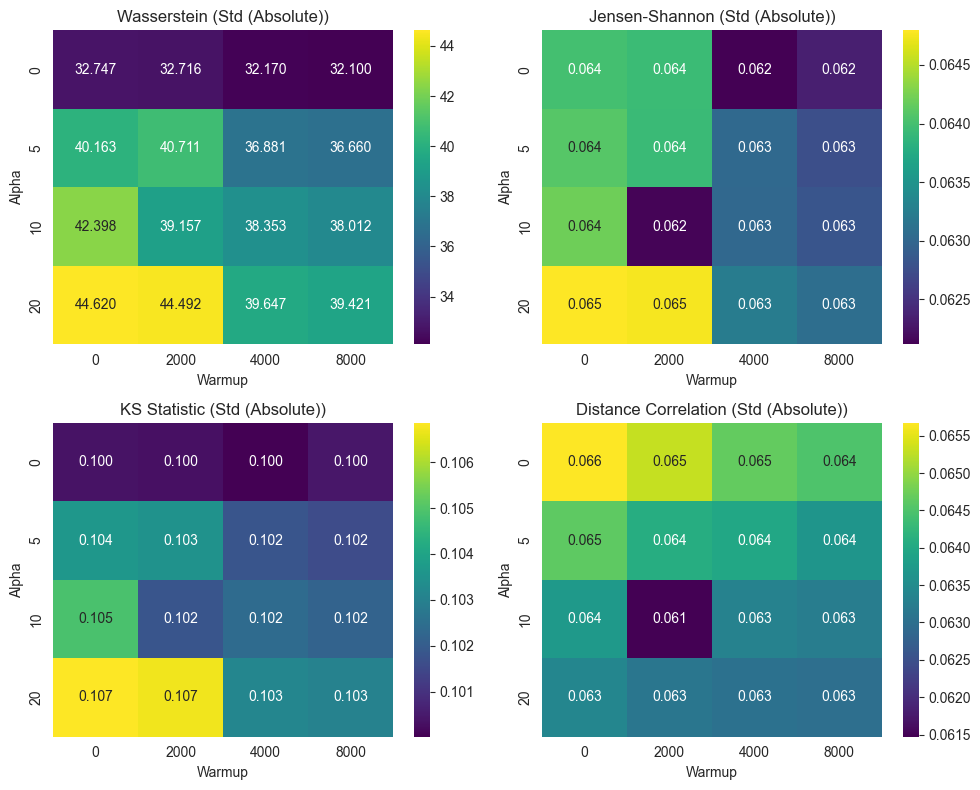

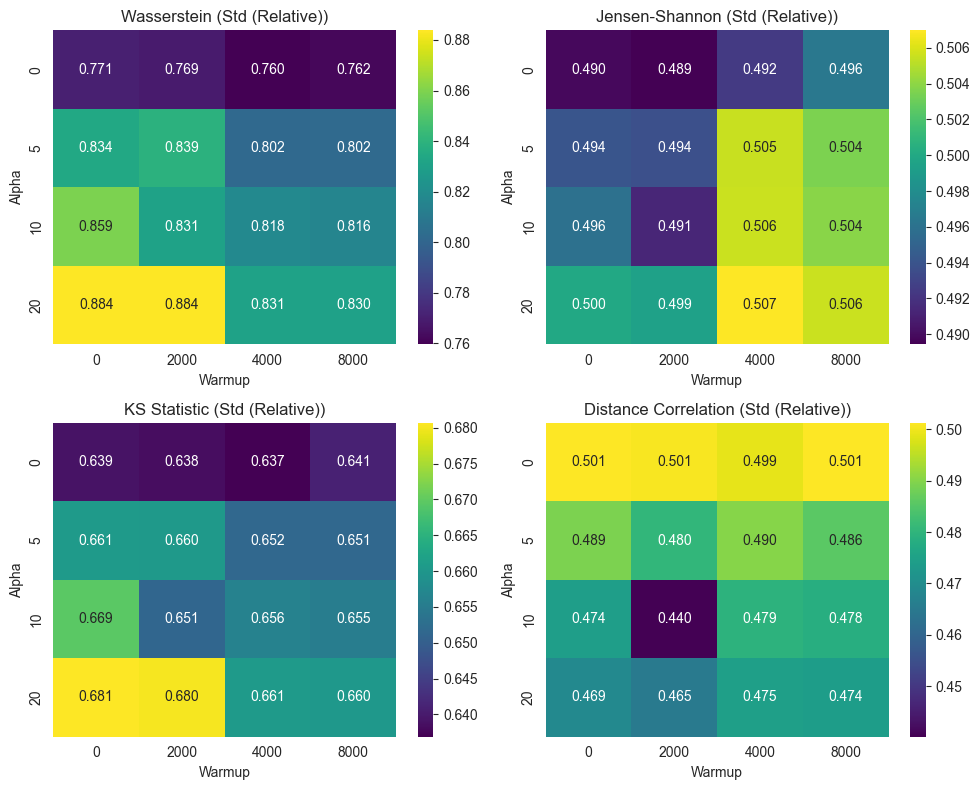

In [15]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# === Metric dictionaries ===
# Each dict: (alpha, warmup): (abs_val, rel_val)
metrics = {
    "Wasserstein": wasserstein,
    "Jensen-Shannon": jensenshannon,
    "KS Statistic": ks_statistic,
    "Distance Correlation": distance_correlation
}

metrics_std = {
    "Wasserstein": wasserstein_std,
    "Jensen-Shannon": jensenshannon_std,
    "KS Statistic": ks_statistic_std,
    "Distance Correlation": distance_correlation_std
}

alpha_grid = [0, 5, 10, 20]
warmup_grid = [0, 2000, 4000, 8000]

# === Helper function to create heatmaps ===
def make_heatmaps(metrics, alpha_grid, warmup_grid, value_index=0, title_suffix="Absolute"):
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    axes = axes.ravel()

    for ax, (name, metric_dict) in zip(axes, metrics.items()):
        # Convert dict to DataFrame with alpha as rows, warmup as columns
        df_metric = pd.DataFrame(index=alpha_grid, columns=warmup_grid, data=np.nan)
        for (alpha, warmup), vals in metric_dict.items():
            if vals is not None and len(vals) > value_index:
                df_metric.loc[alpha, warmup] = vals[value_index]  # 0 for abs, 1 for rel

        sns.heatmap(
            df_metric.astype(float),
            annot=True, fmt=".3f", cmap="viridis",
            cbar=True, ax=ax
        )
        ax.set_title(f"{name} ({title_suffix})")
        ax.set_xlabel("Warmup")
        ax.set_ylabel("Alpha")

    plt.tight_layout()
    return fig

# === Plot mean (absolute and relative) ===
fig_abs = make_heatmaps(metrics, alpha_grid, warmup_grid, value_index=0, title_suffix="Mean (Absolute)")
fig_rel = make_heatmaps(metrics, alpha_grid, warmup_grid, value_index=1, title_suffix="Mean (Relative)")

# === Plot std (absolute and relative) ===
fig_std_abs = make_heatmaps(metrics_std, alpha_grid, warmup_grid, value_index=0, title_suffix="Std (Absolute)")
fig_std_rel = make_heatmaps(metrics_std, alpha_grid, warmup_grid, value_index=1, title_suffix="Std (Relative)")

plt.show()
